In [6]:
# !pip install tensorflow
# !pip install seaborn
# !pip install sklearn
#!pip install xgboost
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

from xgboost import XGBRFClassifier

In [8]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
file = tf.keras.utils
raw_df = pd.read_csv('train.csv')
test_df = pd.read_csv("test.csv")

In [10]:
neg, pos = np.bincount(raw_df['Survived'])
print(neg, pos)

549 342


In [11]:
train, val = train_test_split(raw_df, test_size=0.2)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
578,579,0,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C
527,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
561,562,0,3,"Sivic, Mr. Husein",male,40.00,0,0,349251,7.8958,NaN,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
415,416,0,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,NaN,0,0,343095,8.0500,NaN,S


In [12]:
average_male_age = int(np.mean(train[train["Sex"] == "male"]["Age"]))
average_female_age = int(np.mean(train[train["Sex"] == "female"]["Age"]))
average_fare = np.mean(train["Fare"])

In [13]:
print(average_male_age, average_female_age, average_fare)

30 28 32.86144592696629


In [14]:
from pandas.core.arrays import Categorical
from seaborn import categorical


def age_changer(row):
    if np.isnan(row["Age"]):
        if row["Sex"] == "male":
            return average_male_age
        else:
            return average_female_age
    else:
        return row["Age"] 
#raw_df["Age"] = raw_df.apply(lambda x: age_changer(x), axis=1)

train["Age"] = train.apply(lambda x: age_changer(x), axis=1)
eps = 1
train["Log Fare"] = np.log(np.nan_to_num(train.pop("Fare"))+eps)
le = LabelEncoder()
#1 = male, 0 = female
train["Sex"] = le.fit_transform(train["Sex"])
train_df = train[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Log Fare"]]


val["Age"] = val.apply(lambda x: age_changer(x), axis=1)
val["Log Fare"] = np.log(np.nan_to_num(val.pop("Fare"))+eps)
le = LabelEncoder()
#1 = male, 0 = female
val["Sex"] = le.fit_transform(val["Sex"])
val_df = val[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Log Fare"]]

test_df["Age"] = test_df.apply(lambda x: age_changer(x), axis=1)
test_df["Log Fare"] = np.log(np.nan_to_num(test_df["Fare"])+eps)
le = LabelEncoder()
#1 = male, 0 = female
test_df["Sex"] = le.fit_transform(test_df["Sex"])
test_df = test_df[["PassengerId", "Pclass", "Sex", "Age", "SibSp", "Parch", "Log Fare"]]


In [15]:
print(train_df.head())
print(val_df.head())
print(test_df.head())

     Survived  Pclass  Sex    Age  SibSp  Parch  Log Fare
578         0       3    0  28.00      1      0  2.738146
527         0       1    1  30.00      0      0  5.406181
561         0       3    1  40.00      0      0  2.185579
755         1       2    1   0.67      1      1  2.740840
415         0       3    0  28.00      0      0  2.202765
     Survived  Pclass  Sex    Age  SibSp  Parch  Log Fare
305         1       1    1   0.92      1      2  5.027492
585         1       1    0  18.00      0      2  4.390119
526         1       2    0  50.00      0      0  2.442347
704         0       3    1  26.00      1      0  2.180892
4           0       3    1  35.00      0      0  2.202765
   PassengerId  Pclass  Sex   Age  SibSp  Parch  Log Fare
0          892       3    1  34.5      0      0  2.178064
1          893       3    0  47.0      1      0  2.079442
2          894       2    1  62.0      0      0  2.369075
3          895       3    1  27.0      0      0  2.268252
4          896

In [16]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Survived'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Survived'))
test_passenger_ids = test_df.pop("PassengerId")

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [17]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.fit_transform(val_features)
test_features = scaler.fit_transform(test_features)

In [18]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [256]:
EPOCHS = 50
BATCH_SIZE = 12

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 16)                112       
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 17        
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [257]:
print(model.predict(train_features[:10]))
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
initial_bias = np.log([pos/neg])
print(initial_bias)
model = make_model(output_bias=initial_bias)
print(model.predict(train_features[:10]))
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

1/1 [==============================] - 0s 39ms/step
[[0.383302  ]
 [0.24834494]
 [0.14852357]
 [0.18787453]
 [0.17973062]
 [0.22670512]
 [0.12304725]
 [0.11565243]
 [0.10322304]
 [0.06367183]]
Loss: 0.7336
[-0.4732877]
1/1 [==============================] - 0s 34ms/step
[[0.36296567]
 [0.3807156 ]
 [0.44608074]
 [0.42501485]
 [0.46908414]
 [0.36252007]
 [0.41449615]
 [0.28711122]
 [0.45761186]
 [0.4159941 ]]


In [258]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=40,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [259]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle=":")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

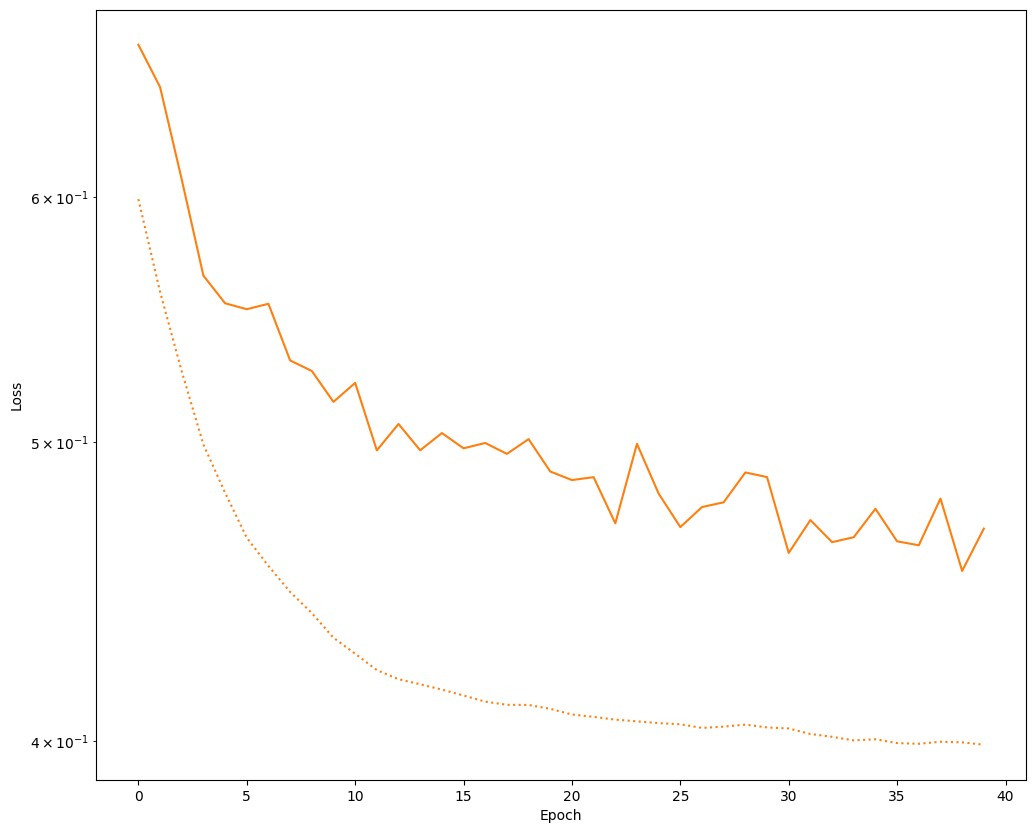

In [260]:
plot_loss(careful_bias_history, "Careful Bias", 1)

In [261]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/50
60/60 [==============================] - 1s 8ms/step - loss: 0.6838 - tp: 114.0000 - fp: 63.0000 - tn: 486.0000 - fn: 228.0000 - accuracy: 0.6734 - precision: 0.6441 - recall: 0.3333 - auc: 0.6682 - prc: 0.5913 - val_loss: 0.6034 - val_tp: 7.0000 - val_fp: 5.0000 - val_tn: 107.0000 - val_fn: 60.0000 - val_accuracy: 0.6369 - val_precision: 0.5833 - val_recall: 0.1045 - val_auc: 0.7401 - val_prc: 0.5866
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6618 - tp: 78.0000 - fp: 59.0000 - tn: 378.0000 - fn: 197.0000 - accuracy: 0.6404 - precision: 0.5693 - recall: 0.2836 - auc: 0.6503 - prc: 0.5060 - val_loss: 0.5608 - val_tp: 17.0000 - val_fp: 4.0000 - val_tn: 108.0000 - val_fn: 50.0000 - val_accuracy: 0.6983 - val_precision: 0.8095 - val_recall: 0.2537 - val_auc: 0.8059 - val_prc: 0.7307
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6031 - tp: 91.0000 - fp: 50.0000 - tn: 387.0000 - fn: 184.0000 - accuracy: 0.6713 - precision:

In [262]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

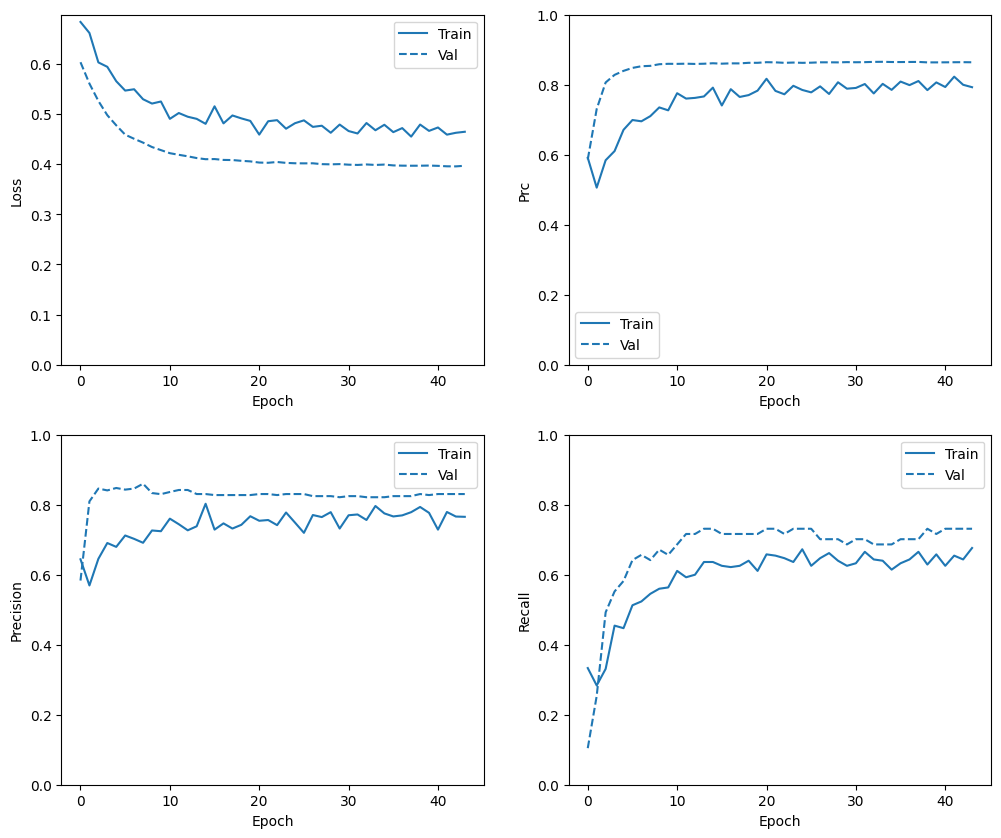

In [263]:
plot_metrics(baseline_history)

In [264]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Dead People Detected (True Negatives): ', cm[0][0])
  print('Dead People Incorrectly Detected (False Positives): ', cm[0][1])
  print('Alive People Marked Dead Missed (False Negatives): ', cm[1][0])
  print('Live people Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

15/15 [==============================] - 0s 641us/step
loss :  0.39852041006088257
tp :  46.0
fp :  10.0
tn :  102.0
fn :  21.0
accuracy :  0.826815664768219
precision :  0.8214285969734192
recall :  0.6865671873092651
auc :  0.8622734546661377
prc :  0.8654729127883911

Dead People Detected (True Negatives):  102
Dead People Incorrectly Detected (False Positives):  10
Alive People Marked Dead Missed (False Negatives):  21
Live people Detected (True Positives):  46
Total Fraudulent Transactions:  67


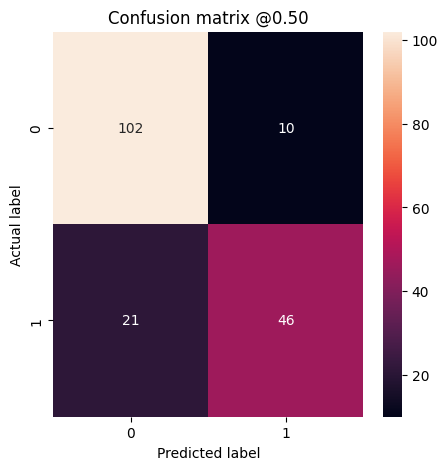

In [265]:
train_predictions_baseline = model.predict(val_features, batch_size=BATCH_SIZE)
baseline_results = model.evaluate(val_features, val_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(val_labels, train_predictions_baseline)

In [28]:
random_forest = RandomForestClassifier()
random_forest.fit(train_features, train_labels)
val_predictions = random_forest.predict(val_features)


In [29]:
sklearn.metrics.confusion_matrix(val_labels,val_predictions)

array([[98, 18],
       [20, 43]], dtype=int64)

In [272]:
test_predictions = random_forest.predict(test_features)

In [287]:
output = pd.DataFrame()
output["PassengerId"] = test_passenger_ids[:-1]
output["Survived"] = test_predictions



In [289]:
output.to_csv("test_predictions.csv", index=False)

In [22]:
xgb_model = XGBRFClassifier(n_estimators=100)

In [20]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(xgb_model, train_features, train_labels, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.815 (0.035)


In [23]:
xgb_model.fit(train_features, train_labels)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='', max_bin=256,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                sampling_method='uniform', scale_pos_weight=1, ...)

In [26]:
xgb_predictions = xgb_model.predict(val_features)

In [27]:
sklearn.metrics.confusion_matrix(val_labels,xgb_predictions)

array([[105,  11],
       [ 18,  45]], dtype=int64)

In [30]:
xgb_predictions_test = xgb_model.predict(test_features)

In [32]:
output = pd.DataFrame()
output["PassengerId"] = test_passenger_ids
output["Survived"] = xgb_predictions_test


In [34]:
output.to_csv("test_predictions_xgb.csv", index=False)